# 2. EDA & Preprocessing

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from copy import deepcopy


# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

In [2]:
seoul_area = gpd.GeoDataFrame.from_file('data/서울시위치정보/LSMD_ADM_SECT_UMD_11.shp')
seoul_area = seoul_area.to_crs(epsg=5181)

In [3]:
# Data Load
df = gpd.GeoDataFrame.from_file('df_final.gpkg')

In [4]:
# 실거래가 없는 상권 제외
len(df.loc[df.평균매매가 == 0, :]) # 51개 상권 > 실거래데이터 없음(제외 필요)
df = df.loc[df.평균매매가 != 0, :]

In [5]:
# 최종 데이터셋 크기
df.shape # 1461 * 49

(1461, 49)

## 변수명/타입 설정

In [6]:
# 변수명 설정
df.columns = ['상권타입', '상권명', '시군구코드', '시군구동코드',
       'nearest_pol_idx', 'Bus', 'Subway', '평균매매가','평균조절가','유흥업소', '살인', '강도', '강간', '절도', '폭력', '방화', '마약',
       '약취', '도박', '전체범죄', '112신고', '총_생활인구', '남성_생활인구', '여성_생활인구',
       '연령대_10_생활인구', '연령대_20_생활인구', '연령대_30_생활인구', '연령대_40_생활인구',
       '연령대_50_생활인구', '연령대_60_이상_생활인구', '시간대_1_생활인구_수', '시간대_2_생활인구_수',
       '시간대_3_생활인구_수', '시간대_4_생활인구_수', '시간대_5_생활인구_수', '시간대_6_생활인구_수', 
       '아파트_단지수', '아파트_평균_시가', '개업_점포_수_비요식업', '개업_점포_수_요식업',
       '점포_수_비요식업', '점포_수_요식업', '폐업_점포_수_비요식업', '폐업_점포_수_요식업',
       '프랜차이즈_점포_수_비요식업', '프랜차이즈_점포_수_요식업', '매출액', '매출건수','geometry']

In [7]:
df = df.drop(['상권명','시군구코드','시군구동코드','nearest_pol_idx'], axis=1) # 불필요한 칼럼 제거

## Pandas Profiling

In [8]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df.drop(['geometry'], axis=1), title='Pandas Profile of Data')
# profile.to_file("pandas_profile.html")

### Dtypes
범죄데이터 1-5단계 object -> integer

In [9]:
crimes = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약',
       '약취', '도박', '전체범죄']
for n in crimes:
    df[n] = df[n].astype('int')

### New Feature

In [10]:
# 심야생활인구비율
df['생활인구_야간비율'] = df['시간대_6_생활인구_수'] / df['총_생활인구'] # 시간대 6(21-24시)
df['생활인구_심야비율'] = df['시간대_1_생활인구_수'] / df['총_생활인구'] # 시간대 1(00-06시)
df['생활인구_여성비율'] = df['여성_생활인구'] / (df['총_생활인구'])
df.head(1)

,상권타입,Bus,Subway,평균매매가,평균조절가,유흥업소,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,112신고,총_생활인구,남성_생활인구,여성_생활인구,연령대_10_생활인구,연령대_20_생활인구,연령대_30_생활인구,연령대_40_생활인구,연령대_50_생활인구,연령대_60_이상_생활인구,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,아파트_단지수,아파트_평균_시가,개업_점포_수_비요식업,개업_점포_수_요식업,점포_수_비요식업,점포_수_요식업,폐업_점포_수_비요식업,폐업_점포_수_요식업,프랜차이즈_점포_수_비요식업,프랜차이즈_점포_수_요식업,매출액,매출건수,geometry,생활인구_야간비율,생활인구_심야비율,생활인구_여성비율
0,골목상권,28,0,481.630544,9.424304,4,1,1,2,2,5,5,1,4,4,5,71472,3720086.0,1736497.0,1983590.0,552455.0,431915.0,469431.0,566236.0,603185.0,1096864.0,1114240.0,734839.0,375534.0,371938.0,593509.0,530027.0,85.0,132737186.0,10.0,6.0,166.0,46.0,13.0,5.0,56.0,55.0,5.035631e+10,3179920.0,"POLYGON ((192008.560 438553.170, 191987.740 43...",0.142477,0.29952,0.533211


In [11]:
# Drop nonusing population features
df = df.drop(['남성_생활인구', '여성_생활인구',
       '연령대_10_생활인구', '연령대_20_생활인구', '연령대_30_생활인구', '연령대_40_생활인구',
       '연령대_50_생활인구', '연령대_60_이상_생활인구', '시간대_1_생활인구_수', '시간대_2_생활인구_수',
       '시간대_3_생활인구_수', '시간대_4_생활인구_수', '시간대_5_생활인구_수', '시간대_6_생활인구_수'], axis=1)

In [12]:
df.to_csv('not_fully_preprocessed.csv', index=False)

### Dummy variable

In [13]:
# 상권타입 to dummy
df = pd.get_dummies(df, columns=['상권타입'], prefix='상권타입', prefix_sep='_')

### Geoplots

In [14]:
# # plot
# cols = df.columns.drop(['geometry', '상권타입_골목상권', '상권타입_관광특구', '상권타입_발달상권', '상권타입_전통시장']).tolist()

# for col in tqdm(cols):
#     fig, ax = plt.subplots(figsize = (15,10))

#     seoul_area.geometry.plot(ax=ax, zorder=1, color='white',alpha=0.6, edgecolor='black', linewidth=0.5)
#     df.plot(column=col, ax=ax, legend=True, zorder=2, cmap='Blues', legend_kwds={'shrink': 0.5})

#     plt.axis('off')
#     plt.suptitle(f'상권별 {col}',fontsize=18)
#     plt.tight_layout()
#     plt.savefig(f'plots/geoplot/상권별 {col}.png', facecolor='white')

## Descriptive Statistics

In [15]:
# describe
df.describe()

,Bus,Subway,평균매매가,평균조절가,유흥업소,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,112신고,총_생활인구,아파트_단지수,아파트_평균_시가,개업_점포_수_비요식업,개업_점포_수_요식업,점포_수_비요식업,점포_수_요식업,폐업_점포_수_비요식업,폐업_점포_수_요식업,프랜차이즈_점포_수_비요식업,프랜차이즈_점포_수_요식업,매출액,매출건수,생활인구_야간비율,생활인구_심야비율,생활인구_여성비율,상권타입_골목상권,상권타입_관광특구,상권타입_발달상권,상권타입_전통시장
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1.461000e+03,1307.000000,1.307000e+03,1456.000000,1446.000000,1456.000000,1446.000000,1456.000000,1446.000000,1456.000000,1446.000000,1.447000e+03,1.447000e+03,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,9.911020,1.828884,1075.595022,10.257871,1.088296,2.611910,2.454483,2.333333,2.673511,2.793292,2.649555,2.543463,2.272416,2.552361,2.701574,87414.731691,3.167396e+06,50.876052,1.989883e+08,15.162088,12.545643,222.738324,67.852697,16.875687,11.195021,35.379121,59.071923,6.230456e+10,2.345522e+06,0.121093,0.232293,0.522173,0.651608,0.004107,0.167009,0.177276
std,7.019271,1.784488,611.970127,0.583470,2.412242,1.540093,1.536368,1.503117,1.500973,1.492808,1.456345,1.583842,1.665027,1.572722,1.473019,31380.593797,3.124393e+06,63.235903,1.669009e+08,24.275817,20.182738,509.914421,107.562067,38.518657,18.481919,56.294969,116.956019,1.785632e+11,4.306155e+06,0.019478,0.062698,0.033006,0.476624,0.063974,0.373112,0.382033
min,0.000000,0.000000,177.664975,7.921088,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28589.000000,3.141000e+03,1.000000,3.314286e+07,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.036897e+06,9.000000e+00,0.016237,0.000000,0.230181,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,671.654115,9.888286,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,68076.000000,9.332670e+05,10.000000,1.276487e+08,4.000000,2.000000,55.750000,17.000000,4.000000,2.000000,8.000000,8.000000,8.165400e+09,4.122605e+05,0.114366,0.194545,0.506685,0.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,931.123471,10.307264,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,90549.000000,2.273400e+06,30.000000,1.527316e+08,8.000000,7.000000,112.000000,35.000000,9.000000,6.000000,20.000000,23.000000,1.991209e+10,1.022521e+06,0.126577,0.242176,0.528346,1.000000,0.000000,0.000000,0.000000
75%,13.000000,3.000000,1322.255663,10.608915,1.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,114534.000000,4.401766e+06,68.500000,2.029534e+08,16.000000,14.000000,208.250000,73.000000,17.000000,12.000000,39.000000,56.000000,4.848939e+10,2.366532e+06,0.133670,0.280219,0.542715,1.000000,0.000000,0.000000,0.000000
max,92.000000,19.000000,8035.714286,11.981290,33.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,139303.000000,2.428423e+07,758.000000,2.334260e+09,264.000000,212.000000,12087.000000,1298.000000,990.000000,194.000000,855.000000,1618.000000,4.327080e+12,5.432867e+07,0.157858,0.380067,0.660248,1.000000,1.000000,1.000000,1.000000


## Correlation

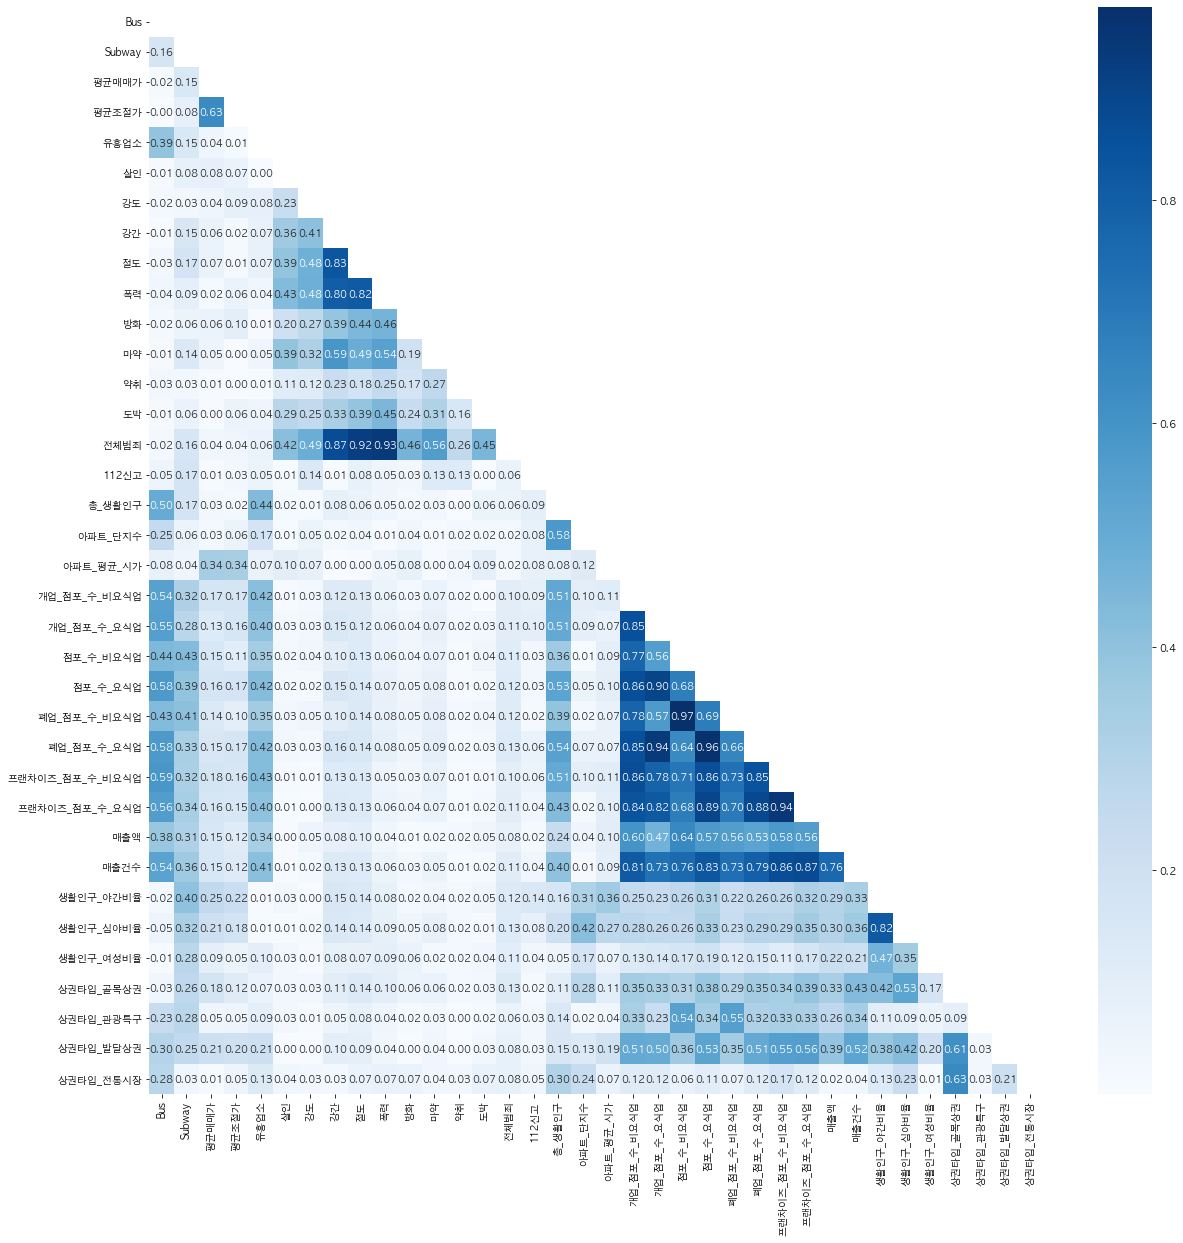

In [16]:
# heatmap > 연령대별 생활인구는 제외
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(20,20))

corr = df.corr().abs() # 연령대 포함한 생활인구변수 제외
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot=True, fmt='.2f')
plt.savefig('plots/corr.png', facecolor='white')
plt.show()

전체범죄, 매출건수, 매출액 상관관계 처리 논의 필요</br>
> 전체범죄 및 매출건수 제외

점포 수 간에 높은 상관관계 > 매출액 및 건수에도 영향
> 비율형 변수로 생성(총 7개)

In [17]:
df['개업율_요식업'] = df['개업_점포_수_요식업'] / df['점포_수_요식업']
df['폐업율_요식업'] = df['폐업_점포_수_요식업'] / df['점포_수_요식업']
df['프랜차이즈비율_요식업'] = df['프랜차이즈_점포_수_요식업'] / df['점포_수_요식업']

In [18]:
df['개업율_비요식업'] = df['개업_점포_수_비요식업'] / df['점포_수_비요식업']
df['폐업율_비요식업'] = df['폐업_점포_수_비요식업'] / df['점포_수_비요식업']
df['프랜차이즈비율_비요식업'] = df['프랜차이즈_점포_수_비요식업'] / df['점포_수_비요식업']

In [19]:
df['요식업비율'] = df['점포_수_요식업'] / (df['점포_수_요식업'] + df['점포_수_비요식업'])

In [20]:
# df = df.drop(['전체범죄','매출건수'], axis=1)
df = df.drop(df.columns[df.columns.str.contains('점포_수')].tolist(), axis=1)

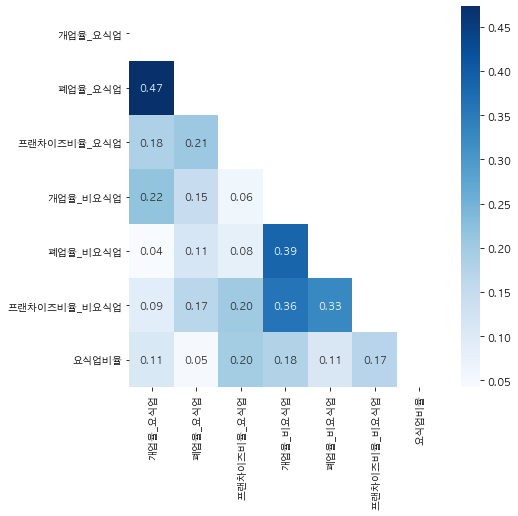

In [21]:
# heatmap for new variables
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(7,7))

corr = df.iloc[:,-7:].corr().abs() # 연령대 포함한 생활인구변수 제외
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot=True, fmt='.2f')
plt.savefig('plots/corr_new.png', facecolor='white')
plt.show()

## Outlier Detection

### Boxplot

In [22]:
cols = df.columns.drop(['geometry', '상권타입_골목상권', '상권타입_관광특구', '상권타입_발달상권', '상권타입_전통시장']).tolist()
cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박'] # 9종 범죄
len(cols)

31

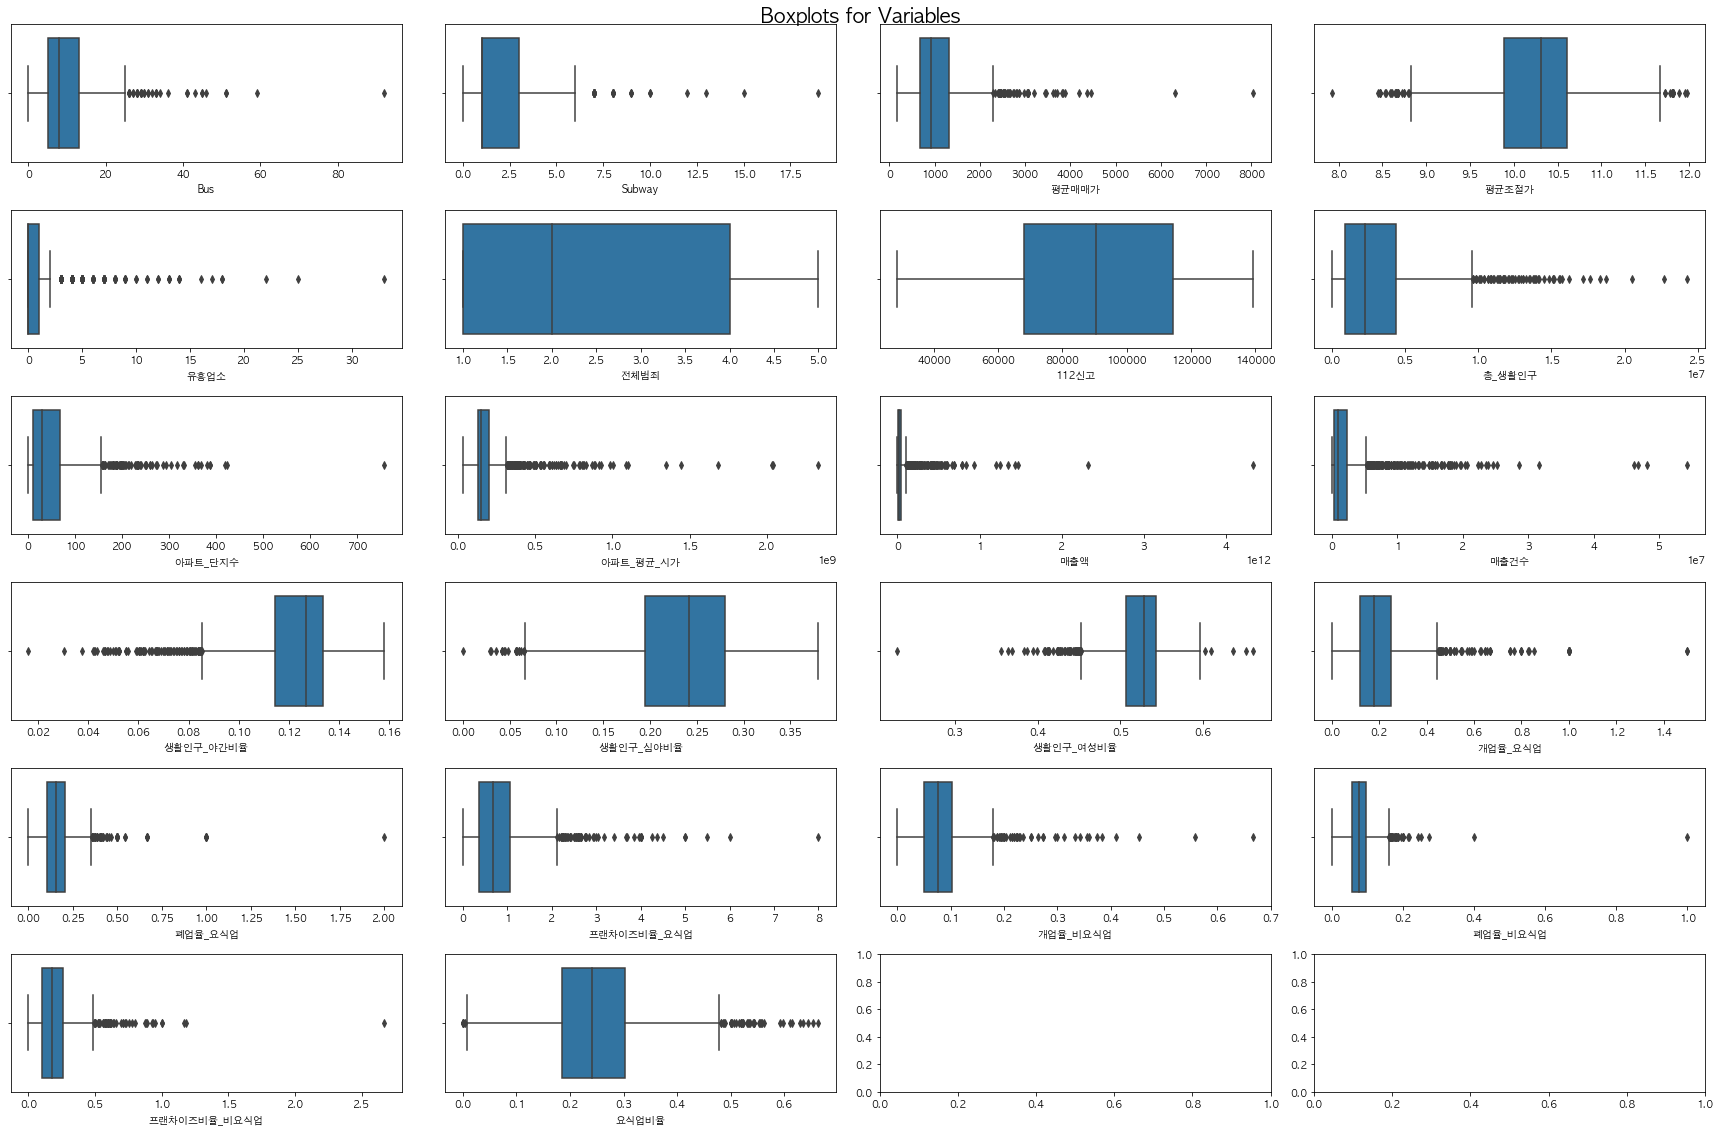

In [23]:
figs, axes = plt.subplots(nrows=6,ncols=4, figsize=(24,16))
for idx, col in enumerate([x for x in cols if x not in cols_crime]):
    ax_i = axes[idx//4, idx%4]
    sns.boxplot(x=df[col], ax=ax_i)
plt.suptitle('Boxplots for Variables', fontsize=20)
plt.tight_layout()
plt.savefig('plots/Box.png', facecolor='white') # 면적당 매매가(1,3)에 비해 조절가격(1,4)가 더 outlier에 robust하다

In [24]:
# z-score for responsive variable
col = '평균매매가'
zscore =((df[col]-df[col].mean())/df[col].std()).abs()
zscore.sort_values(ascending=False).head(3)
# np.where(zscore_y>4)

196     11.373299
1376     8.572042
342      5.533198
Name: 평균매매가, dtype: float64

In [25]:
# z-score for responsive variable
col = '평균조절가'
zscore =((df[col]-df[col].mean())/df[col].std()).abs()
zscore.sort_values(ascending=False).head(3)
# np.where(zscore_y>4)

94     4.004980
796    3.105138
998    3.060682
Name: 평균조절가, dtype: float64

In [26]:
# outlier drop
df = df.drop(index=94, axis=0)

## Scaling


### KDE Plot

In [27]:
# variables
cols = df.columns.drop(['geometry', '상권타입_골목상권', '상권타입_관광특구', '상권타입_발달상권', '상권타입_전통시장']).tolist()
len(cols)

31

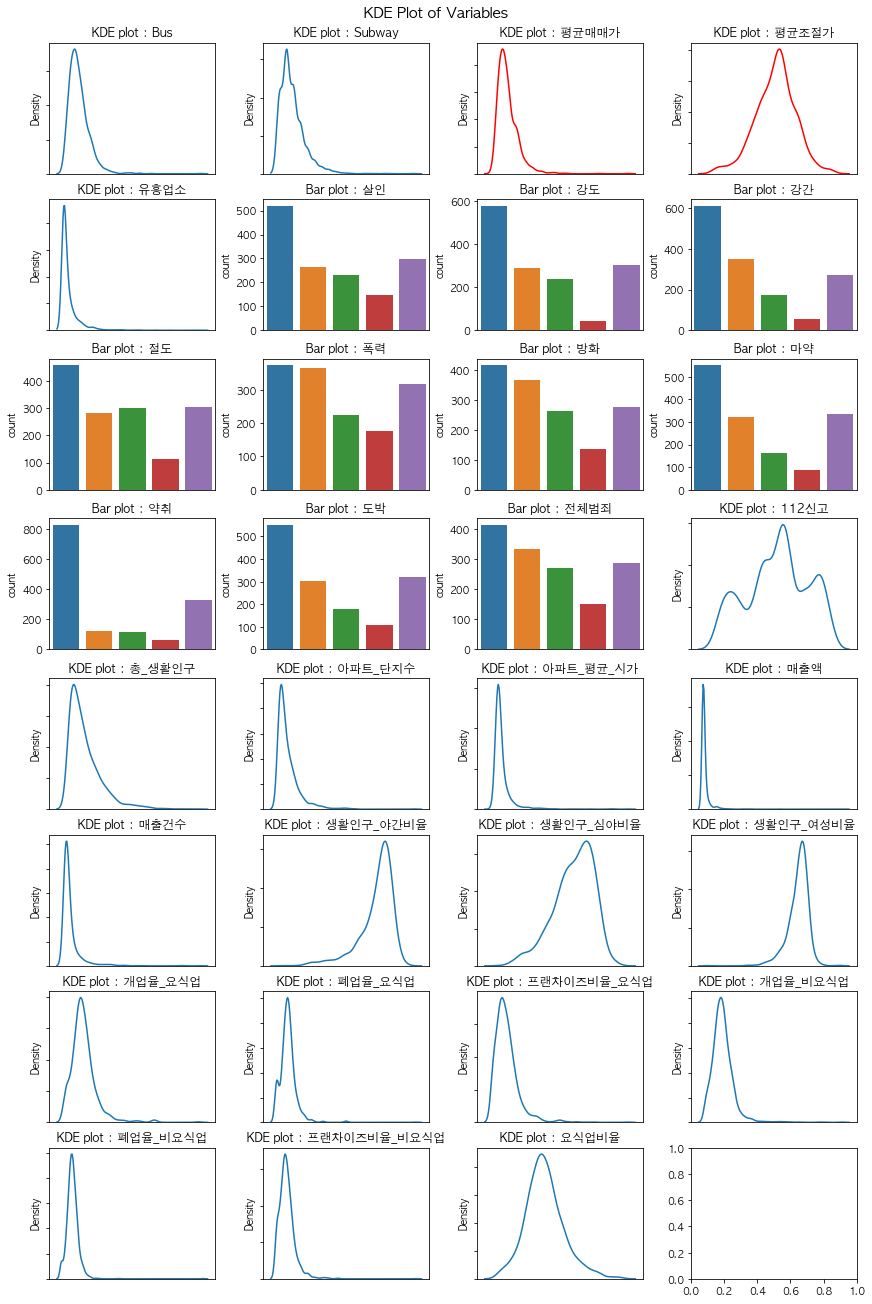

In [28]:
# KDE plots of Variables

figs, axes = plt.subplots(nrows=8, ncols=4, figsize = (12,18), constrained_layout=True)

cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박','전체범죄']

for idx, col in enumerate(cols):
    ax_i = axes[idx//4, idx%4]
    if col in cols_crime:
        sns.countplot(data=df, x=col, ax=ax_i)
        ax_i.set_title(f'Bar plot : {col}')
        ax_i.get_xaxis().set_visible(False)
    else:
        if col == '평균매매가' or col == '평균조절가':
            sns.kdeplot(df[col], ax = ax_i, color='red')
        else:
            sns.kdeplot(df[col], ax = ax_i)
        ax_i.set_title(f'KDE plot : {col}')
        ax_i.tick_params(labelleft=False,labelbottom=False)
        ax_i.get_xaxis().set_visible(False)

plt.suptitle('KDE Plot of Variables', fontsize=15)
plt.savefig('plots/KDE.png', facecolor='white')
plt.show()


#### Shapiro-Wilk Test
Normality Test를 통해 각 변수들의 정규성을 진단하고, 정규성 확보가 필요한 경우 Transformation 시행

In [29]:
from scipy.stats import shapiro
df_shapiro = pd.DataFrame(columns=['col','statistic','pval'])
ls_col = []
ls_stats = []
ls_pval = []
for col in [x for x in cols if x not in cols_crime]: # except crime data
    shapiro_col = shapiro(df[col])
    ls_col.append(col)
    ls_stats.append(shapiro_col[0])
    ls_pval.append(shapiro_col[1])
    
df_shapiro['col'] = ls_col
df_shapiro['statistic'] = ls_stats
df_shapiro['pval'] = ls_pval
df_shapiro.round(4)

,col,statistic,pval
0,Bus,0.8406,0.0
1,Subway,0.8077,0.0
2,평균매매가,0.8168,0.0
3,평균조절가,0.9911,0.0
4,유흥업소,0.4922,0.0
5,112신고,0.9562,0.0
6,총_생활인구,0.8174,0.0
7,아파트_단지수,NaN,1.0
8,아파트_평균_시가,NaN,1.0
9,매출액,NaN,1.0


In [30]:
e

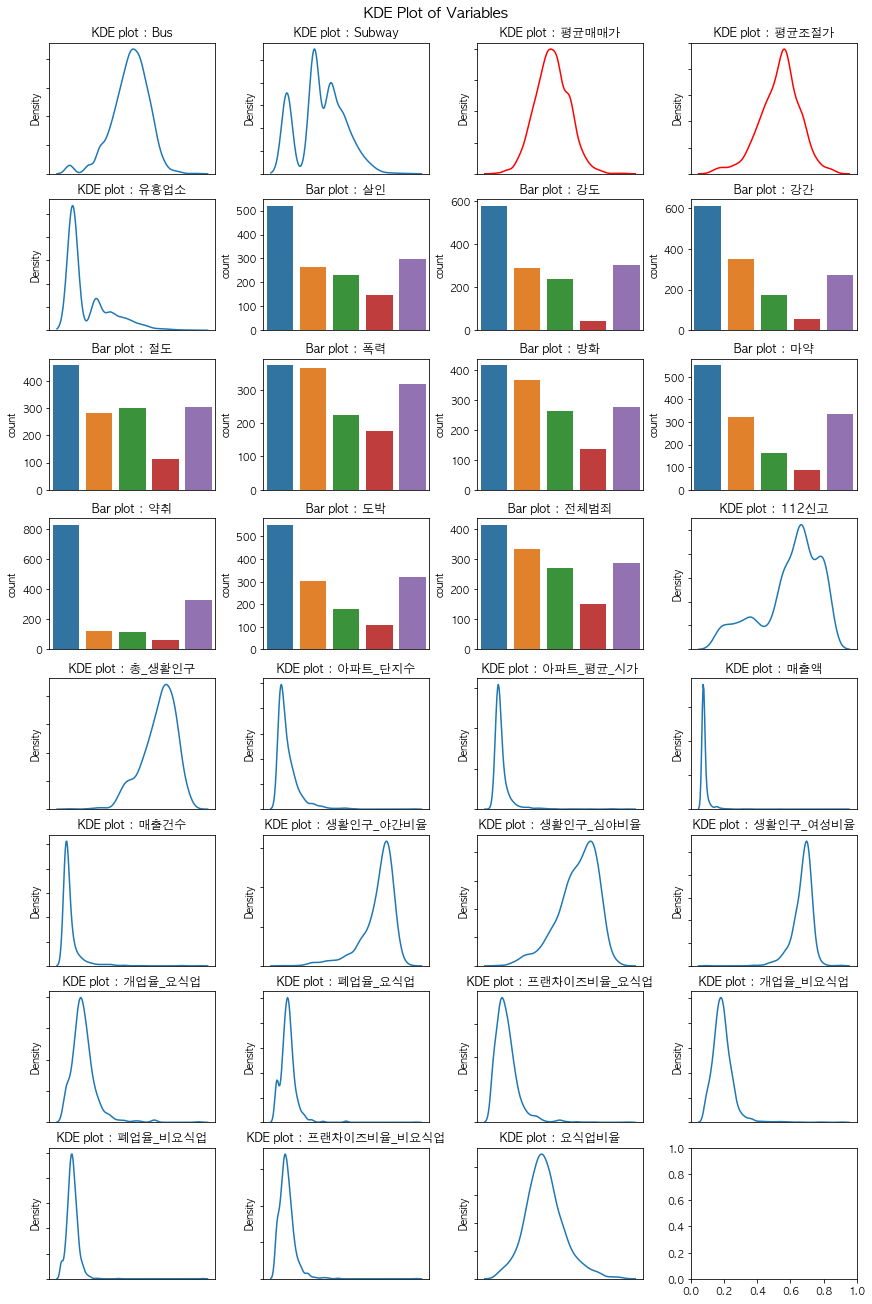

In [31]:
# KDE plots of Variables

figs, axes = plt.subplots(nrows=8, ncols=4, figsize = (12,18), constrained_layout=True)

cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박','전체범죄']

for idx, col in enumerate(cols):
    ax_i = axes[idx//4, idx%4]
    if col in cols_crime:
        sns.countplot(data=df_trans, x=col, ax=ax_i)
        ax_i.set_title(f'Bar plot : {col}')
        ax_i.get_xaxis().set_visible(False)
    else:
        if col == '평균매매가' or col == '평균조절가':
            sns.kdeplot(df_trans[col], ax = ax_i, color='red')
        else:
            sns.kdeplot(df_trans[col], ax = ax_i)
        ax_i.set_title(f'KDE plot : {col}')
        ax_i.tick_params(labelleft=False,labelbottom=False)
        ax_i.get_xaxis().set_visible(False)

plt.suptitle('KDE Plot of Variables', fontsize=15)
plt.savefig('plots/KDE.png', facecolor='white')
plt.show()


In [32]:
# shapiro retest
df_trans_shapiro = pd.DataFrame(columns=['col','statistic','pval'])
ls_col = []
ls_stats = []
ls_pval = []
for col in [x for x in cols if x not in cols_crime]: # except crime data
    shapiro_col = shapiro(df_trans[col])
    ls_col.append(col)
    ls_stats.append(shapiro_col[0])
    ls_pval.append(shapiro_col[1])
    
df_trans_shapiro['col'] = ls_col
df_trans_shapiro['statistic'] = ls_stats
df_trans_shapiro['pval'] = ls_pval
df_trans_shapiro.round(4)

,col,statistic,pval
0,Bus,0.9677,0.0000
1,Subway,0.9218,0.0000
2,평균매매가,0.9979,0.0574
3,평균조절가,0.9845,0.0000
4,유흥업소,0.7085,0.0000
5,112신고,0.9036,0.0000
6,총_생활인구,0.9597,0.0000
7,아파트_단지수,NaN,1.0000
8,아파트_평균_시가,NaN,1.0000
9,매출액,NaN,1.0000


## Save

In [33]:
df = df[df.columns.drop('geometry')]
df_trans = df_trans[df_trans.columns.drop('geometry')]

In [34]:
df.to_csv('df_preprocessed.csv', index=False)
df_trans.to_csv('df_transformed.csv', index=False)